In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# **1. Xây dựng code mô hình**
---



# **Lớp Node**

- Mỗi `Node` biểu diễn một nút trong cây quyết định.
- Nếu là node lá (leaf node), nó chỉ lưu `value` là nhãn dự đoán.
- Nếu là node quyết định (decision node), nó lưu thông tin chia: `feature`, `threshold`, `left`, `right`.

In [2]:
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value
  def is_leaf_node(self):
    return self.value is not None

# **Lớp DecisionTree**
- Method grow_tree: Nuôi cây cho lớn và chạy đệ quy
- Method best_split: Tìm feature và threshold tốt nhất dựa trên Gini gain
- Method gini_gain: Tính chỉ số Gini để đo mức độ lẫn lộn của lớp Node
- Có 2 siêu tham số (`hyperparameters`) quan trọng:
  - `max_depth`: kiểm soát overfitting bằng cách giới hạn độ sâu.
  - `min_samples_split`: nếu số mẫu nhỏ hơn ngưỡng này thì không chia nữa.

In [3]:
class DecisionTreeClassifier:
  def __init__(self, min_samples_split=2, max_depth=100):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.root=None

  def fit(self, X, y):
    self.root = self.grow_tree(X, y)

  def grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(set(y))

    if (n_labels == 1 or depth >= self.max_depth or n_samples < self.min_samples_split):
      leaf_value = self.most_common_label(y)
      return Node(feature=None, threshold=None, left=None, right=None, value=leaf_value)

    best_feature, best_threshold = self.best_split(X, y, n_features)
    left_idx=(X[:,best_feature] <= best_threshold)
    right_idx= (X[:,best_feature] > best_threshold)

    left = self.grow_tree(X[left_idx], y[left_idx], depth+1)
    right = self.grow_tree(X[right_idx], y[right_idx], depth+1)

    return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

  def best_split(self, X, y, n_features):
    best_feature, best_threshold = None, None
    best_gain=-1

    for feat in range(n_features):
      thresholds = np.unique(X[:,feat])
      for thres in thresholds:
        left = X[:, feat] <= thres
        right = X[:, feat] > thres
        if (len(y[left])==0 or len(y[right])==0):
          continue
        gain = self.gini_gain(y, y[left], y[right])
        if best_gain < gain:
          best_gain = gain
          best_feature = feat
          best_threshold = thres
    return best_feature, best_threshold

  def gini(self, y):
    classes = np.unique(y)
    imp=1.0
    for c in classes:
      p = np.sum(y==c)/len(y)
      imp -= p**2
    return imp

  def gini_gain(self, y, left, right):
    n=len(y)
    n_left = len(left)
    n_right = len(right)

    child = n_left/n*self.gini(left) + n_right/n*self.gini(right)
    return self.gini(y) - child

  def most_common_label(self, y):
    return np.bincount(y).argmax()

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def _traverse_tree(self, x, node):
      if node.value is not None:
          return node.value

      if x[node.feature] <= node.threshold:
          return self._traverse_tree(x, node.left)
      else:
          return self._traverse_tree(x, node.right)


most_common_label

- Dùng khi cần gán nhãn cho node lá.
- Lấy nhãn xuất hiện nhiều nhất trong tập y.

# **2. Chuẩn bị tệp dữ liệu**

---



In [4]:
df = pd.read_csv('/content/train_balanced.csv')
df.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,...,Stroke,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,0,-0.167619,-0.424070,-0.490039,-0.067601,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0
1,0,-0.722991,-0.424070,-0.238631,-0.067601,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,1.0,4.0,0.0,0.0,0.0
2,0,-0.147166,-0.424070,-0.490039,0.628776,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,11.0,0.0,1.0,4.0,0.0,0.0,0.0
3,0,-1.003038,-0.424070,0.389886,0.628776,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,1.0,2.0,0.0,1.0,0.0
4,1,-0.000849,3.349118,-0.490039,0.628776,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0


In [5]:
df.describe()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,...,Stroke,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.500000,0.076887,0.251070,0.046521,0.011804,0.018475,0.01895,0.066150,0.070725,0.033450,...,0.093300,0.242975,0.525825,7.767675,0.695475,0.710375,2.217975,0.155375,0.077250,0.133150
std,0.500006,1.024066,1.250976,1.078727,1.107455,0.134663,0.13635,0.248547,0.256368,0.179811,...,0.290856,0.428885,0.499339,3.364771,1.241945,0.453594,1.139427,0.362266,0.266991,0.339741
min,0.000000,-2.505534,-0.424070,-0.490039,-4.245859,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.619154,-0.424070,-0.490039,-0.763977,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.500000,-0.081087,-0.424070,-0.490039,-0.067601,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,1.000000,0.584416,0.204795,-0.112928,0.628776,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,10.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000
max,1.000000,8.601923,3.349118,3.281069,11.770800,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,12.000000,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000


In [6]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X = X.values
y = y.values

In [7]:
def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    n_samples = len(X)
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(n_samples)
    test_count = int(n_samples * test_size)

    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    X_train = X[train_idx]
    X_test  = X[test_idx]
    y_train = y[train_idx]
    y_test  = y[test_idx]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

HeartDisease
0    20000
1    20000
Name: count, dtype: int64


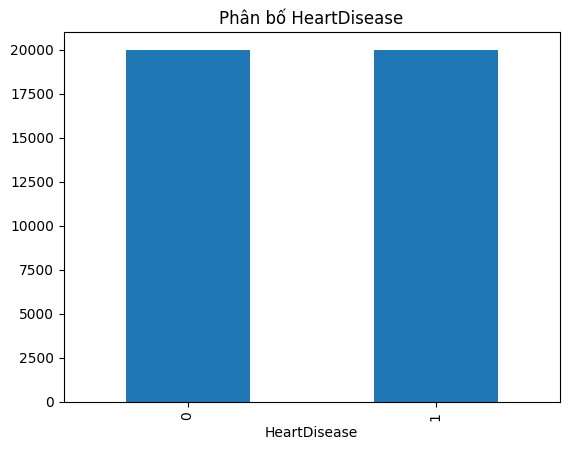

In [8]:
target_counts = df['HeartDisease'].value_counts()
print(target_counts)
target_counts.plot(kind='bar')
plt.title("Phân bố HeartDisease")
plt.show()

Tệp data này đã được cân bằng lớp rất tốt

# **3. Cross Validation để tìm bộ siêu tham số tối ưu**
Stratified K-Fold


---



Hàm Stratified K Fold

In [ ]:
def stratified_k_fold(y, k=5, shuffle=True):
    y = np.array(y)
    folds = [[],[],[],[],[]]

    for cls in np.unique(y):
        idx_list = np.where(y == cls)[0]
        split = np.array_split(idx_list, k)

        for i in range(k):
            folds[i].extend(split[i])

    folds = [np.array(fold) for fold in folds]
    return folds


*Chạy Folds*

In [ ]:
results = []

depths = [2, 4, 6, 8]
min_samples_splits = [2, 5, 10]

folds = stratified_k_fold(y, k=5)

for depth in depths:
    for min_split in min_samples_splits:
        scores = []

        for i in range(5):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(5) if j != i])

            model = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_split=min_split
            )

            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[val_idx])

            acc = np.mean(y_pred == y[val_idx])
            scores.append(acc)

        mean_acc = np.mean(scores)

        results.append({
            "max_depth": depth,
            "min_samples_split": min_split,
            "cv_accuracy": mean_acc
        })

        print(
            f"max_depth={depth}, "
            f"min_samples_split={min_split}, "
            f"CV accuracy={mean_acc:.3f}"
        )


max_depth=2, min_samples_split=2, CV accuracy=0.716
max_depth=2, min_samples_split=5, CV accuracy=0.716
max_depth=2, min_samples_split=10, CV accuracy=0.716
max_depth=4, min_samples_split=2, CV accuracy=0.744
max_depth=4, min_samples_split=5, CV accuracy=0.744
max_depth=4, min_samples_split=10, CV accuracy=0.744
max_depth=6, min_samples_split=2, CV accuracy=0.752
max_depth=6, min_samples_split=5, CV accuracy=0.752
max_depth=6, min_samples_split=10, CV accuracy=0.752
max_depth=8, min_samples_split=2, CV accuracy=0.751
max_depth=8, min_samples_split=5, CV accuracy=0.751
max_depth=8, min_samples_split=10, CV accuracy=0.751


# **4. Huấn luyện mô hình với tệp dữ liệu**


---



In [ ]:
X_train = X_train.values
y_train = y_train.values

In [9]:
model = DecisionTreeClassifier(max_depth=6, min_samples_split=5)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test.values)

In [ ]:
y_pred = model.predict(X_test.values)
accuracy = np.mean(y_pred == y_test.values)

print("Accuracy:", accuracy)

Accuracy: 0.75375


*Xuất model ra file pickle để sử dụng cho demo*

In [10]:
import joblib
joblib.dump(model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

# **6. Kết quả kiểm tra**

---



In [ ]:
train_acc = np.mean(model.predict(X_train) == y_train)
test_acc  = np.mean(model.predict(X_test.values) == y_test)

print("Train accuracy:", train_acc)
print("Test accuracy :", test_acc)

Train accuracy: 0.75646875
Test accuracy : 0.75375


Do sử dụng tệp data đã qua cân bằng lớp nên chỉ số Accuracy không còn đáng tin cậy. Ở đây ta chỉ kiểm tra mô hình có Overfitting hay không dựa trên Accuracy của mô hình trên tệp train và test. Kết quả đưa ra mô hình không bị Overfitting do 2 giá trị gần như cân bằng nhau.

In [ ]:
def confusion_matrix_manual(y_true, y_pred):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_idx = {label: i for i, label in enumerate(labels)}

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1

    return cm, labels
cm, labels = confusion_matrix_manual(y_test, y_pred)
print("Labels:", labels)
print("Confusion Matrix:\n", cm)

Labels: [0 1]
Confusion Matrix:
 [[2732 1263]
 [ 707 3298]]


In [ ]:
def precision_recall_f1(cm):
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    return precision, recall, f1
precision, recall, f1 = precision_recall_f1(cm)
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1       : {f1:.3f}")

Precision: 0.723
Recall   : 0.823
F1       : 0.770


Kết quả cuối cùng đạt được với **Recall trên 80%** và với dự đoán có bệnh của mô hình trong tập test lên đến **72%**. Một kết quả tốt của mô hình cho bài toán dự đoán bệnh tim trong y tế.



# **7. Huấn luyện với data gốc mất cân bằng để kiểm thử**


---



In [ ]:
df_root = pd.read_csv('/content/heart_2020_processed.csv')
df_root.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,...,Stroke,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,0,-1.844750,-0.046751,3.281069,-1.460354,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,3.0,1.0,3.0,1.0,0.0,1.0
1,0,-1.256338,-0.424070,-0.490039,-0.067601,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,12.0,0.0,1.0,3.0,0.0,0.0,0.0
2,0,-0.274603,2.091388,3.281069,0.628776,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,9.0,3.0,1.0,1.0,1.0,0.0,0.0
3,0,-0.647473,-0.424070,-0.490039,-0.763977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,0.0,0.0,2.0,0.0,0.0,1.0
4,0,-0.726138,3.097572,-0.490039,0.628776,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,0.0,0.0


In [ ]:
X_root = df_root.drop('HeartDisease', axis=1)
y_root = df_root['HeartDisease']
X_root = X_root.values
y_root = y_root.values

In [ ]:
from sklearn.model_selection import train_test_split
X_train_root, X_test_root, y_train_root, y_test_root = train_test_split(X_root, y_root, test_size=0.2, random_state=42)

In [ ]:
model = DecisionTreeClassifier(max_depth=6, min_samples_split=5)
model.fit(X_train_root, y_train_root)

In [ ]:
y_pred = model.predict(X_test_root)
accuracy = np.mean(y_pred_root == y_test_root)

print("Accuracy:", accuracy)

Accuracy: 0.9197358767424798


In [ ]:
train_acc = np.mean(model.predict(X_train_root) == y_train_root)
test_acc  = np.mean(model.predict(X_test_root) == y_test_root)

print("Train accuracy:", train_acc)
print("Test accuracy :", test_acc)

Train accuracy: 0.9169724097446433
Test accuracy : 0.9197358767424798


In [ ]:
def confusion_matrix_manual(y_true, y_pred):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_idx = {label: i for i, label in enumerate(labels)}

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[label_to_idx[t], label_to_idx[p]] += 1

    return cm, labels
cm, labels = confusion_matrix_manual(y_test_root, y_pred)
print("Labels:", labels)
print("Confusion Matrix:\n", cm)

Labels: [0 1]
Confusion Matrix:
 [[6215   46]
 [ 501   53]]


In [ ]:
def precision_recall_f1(cm):
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    return precision, recall, f1
precision, recall, f1 = precision_recall_f1(cm)
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1       : {f1:.3f}")

Precision: 0.535
Recall   : 0.096
F1       : 0.162


Dù kết quả đo độ chính xác của Train và Test đều cao và gần giống nhau, không bị overfitting, nhưng thực tế, khi đo bằng thước đo chuẩn hơn thì có thể thấy, chỉ số Precision là 0.579 và Recall chỉ 0.04. Mô hình rất ít khi đưa ra dự đoán có bệnh (Recall rất thấp), và chỉ đưa ra nếu chắc chắn. Vì vậy, tệp dữ liệu này **rất tệ** nếu dùng để dự đoán y tế một người có bệnh hay không. Do đó, đề tài đã sử dụng phương pháp Random Undersampling để cân bằng lại lớp và đưa ra kết quả tối ưu hơn.

# **8. Lưu kết quả dự đoán thành file csv để phục vụ quá trình Ensamble Learning**


---



In [ ]:
y_pred_all = model.predict(X)

In [ ]:
y_pred_all.shape

(40000,)

In [ ]:
pd.DataFrame({'y_pred': y_pred_all}).to_csv(
    'DecisionTree_y_pred.csv',
    index=False
)